# **Deep learning for dynamic network analysis (DLDNA) - Final project**
**Dolphins:** R. ARNAUD M. DELPLANQUE A. KARILA-COHEN A. RAMPOLDI <br> **Dataset:** Comprehensive soil classification dataset: https://www.kaggle.com/datasets/ai4a-lab/comprehensive-soil-classification-datasets/code

_______________

# Notebook 1 — Vision Transformer with Attention Mechanisms

> **This notebook investigates the use of attention-based architectures for soil image classification, using a Swin Transformer Tiny pretrained model (```swin_model.pt```).**
>
> ### Motivation
> Unlike CNNs, transformers rely on self-attention mechanisms to capture long-range spatial dependencies. This is particularly relevant for soil images where texture and global patterns may be more informative than local features alone.
> |
> ### Model Description
> A Swin Transformer Tiny pre-trained on ImageNet is fine-tuned for a 7-class soil classification task by replacing the final classification layer.  
> Class imbalance is handled using weighted cross-entropy loss computed from the training set.

### Training Strategy
- Optimizer: AdamW with weight decay,
- Learning rate scheduling: StepLR,
- Model checkpointing based on validation accuracy.

### Output
This notebook provides:
- Transformer-based classification results,
- A reference model for comparison with CNN and GAN-augmented approaches.

______________________________

### **1. Preliminnary tasks**

**1.1. Install and import the libraries**

In [2]:
#install the needed libraries
# pip install timm

In [18]:
# --- 1. Standard Library ---
import os
import time
import copy

# --- 2. Data Science & Math ---
import numpy as np

# --- 3. Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- 4. PyTorch Ecosystem ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# --- 5. Advanced Computer Vision Models ---
import timm

# --- 6. Scikit-Learn (Metrics & Utils) ---
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc, 
    accuracy_score, 
    f1_score, 
    precision_score, 
    recall_score
)

**1.2. Choose the good torch device**

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'xpu' if hasattr(torch, "xpu") and torch.xpu.is_available() else 'cpu'
print(f"Params loaded. Device: {DEVICE}")

Params loaded. Device: cuda


**1.3. General parameters**

In [19]:
# General parameters
TRAIN_RATIO  = 0.7
VAL_RATIO    = 0.1
TEST_RATIO   = 0.2
BATCH_SIZE = 32
IMG_SIZE = 224
EPOCHS = 10
LEARNING_RATE = 5e-5
NUM_CLASSES = 7

SEED = 42 # Important: we all use the SAME seed in the group!

current_path = os.getcwd()
DATA_DIR = os.path.join(current_path, '..', 'data', 'Orignal-Dataset')



# Create the directory if it doesn't exist
OUTPUT_DIR = os.path.join(current_path, '..', 'results', 'Attention')
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory set to: {OUTPUT_DIR}")

Output directory set to: c:\Users\alera\Desktop\ENTPE\Deep Learning\Project\notebooks\..\results\Attention


### 2. Splitting the dataset

In [22]:
# --- 1. DATA TRANSFORMATIONS ---

# Train: Data Augmentation (No Black Borders Strategy)
train_transforms = transforms.Compose([
    # RandomResizedCrop replaces the standard Resize + Rotation approach.
    # - scale=(0.8, 1.0): Crops a random portion between 80% and 100% of the original image (Mild Zoom)
    # - ratio=(0.9, 1.1): Maintains aspect ratio close to square (prevents excessive distortion)
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    
    # Color and Lighting adjustments (Crucial for Soil Texture)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.01),
    
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # Note: RandomRotation was removed because RandomResizedCrop already provides geometric variation without creating artifacts
    
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Eval (Val/Test): Clean images, only resize and normalize
eval_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# --- 2. DATA LOADING ---
# We create two instances of the dataset: one with augs, one without
full_data_train = datasets.ImageFolder(root=DATA_DIR, transform=train_transforms)
full_data_eval  = datasets.ImageFolder(root=DATA_DIR, transform=eval_transforms)

indices = list(range(len(full_data_train)))
targets = full_data_train.targets

# --- 3. SPLIT STRATEGY (Dynamic based on Ratios) ---

# PHASE 1: Split Training from the rest (Validation + Test)
# The size of "rest" is (1 - TRAIN_RATIO)
train_idx, rest_idx = train_test_split(
    indices, 
    test_size=(1 - TRAIN_RATIO), 
    random_state=SEED, 
    stratify=targets
)

# PHASE 2: Split the "Rest" into Validation and Test
# Logic: We need to find the proportion of Test set relative to the Rest.
# Example: If Val=0.1 and Test=0.2, then Rest=0.3.
# The Test portion inside Rest is 0.2 / 0.3 = 0.66 (2/3).
relative_test_size = TEST_RATIO / (VAL_RATIO + TEST_RATIO)

rest_targets = [targets[i] for i in rest_idx] # Targets for stratification
val_idx, test_idx = train_test_split(
    rest_idx, 
    test_size=relative_test_size, 
    random_state=SEED, 
    stratify=rest_targets
)

# --- 4. SUBSETS & DATALOADERS ---
train_dataset = Subset(full_data_train, train_idx)
val_dataset   = Subset(full_data_eval, val_idx)
test_dataset  = Subset(full_data_eval, test_idx)

# Note: num_workers=0 is safer on Windows to avoid BrokenPipeError. Change to 2 if on Linux/Colab.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# --- 5. VERIFICATION ---
total = len(indices)
print(f"Data Loaded Successfully!")
print(f"Total Images: {total}")
print(f"Training Set:   {len(train_dataset)} images ({len(train_dataset)/total:.2%}) -> Target: {TRAIN_RATIO*100}%")
print(f"Validation Set: {len(val_dataset)} images ({len(val_dataset)/total:.2%}) -> Target: {VAL_RATIO*100}%")
print(f"Test Set:       {len(test_dataset)} images ({len(test_dataset)/total:.2%}) -> Target: {TEST_RATIO*100}%")
print(f"Classes found: {full_data_train.classes}")

Data Loaded Successfully!
Total Images: 1189
Training Set:   832 images (69.97%) -> Target: 70.0%
Validation Set: 119 images (10.01%) -> Target: 10.0%
Test Set:       238 images (20.02%) -> Target: 20.0%
Classes found: ['Alluvial_Soil', 'Arid_Soil', 'Black_Soil', 'Laterite_Soil', 'Mountain_Soil', 'Red_Soil', 'Yellow_Soil']


### 3. Simple data augmentation


Visualizing dataset samples...


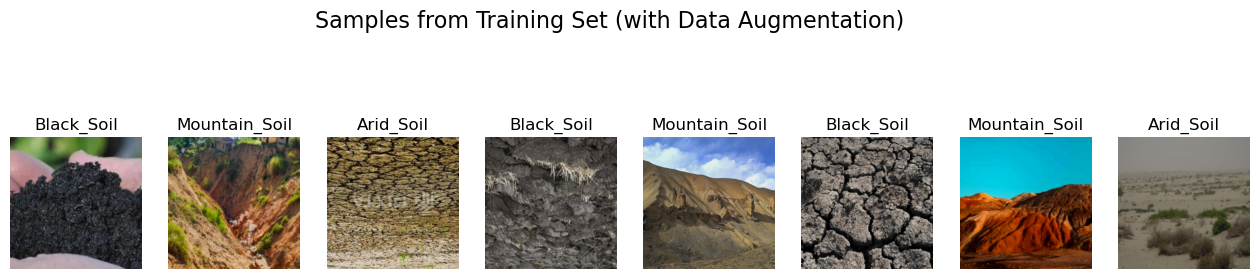

In [6]:
# Function to display a batch of images
def show_dataset_samples(loader, class_names):
    # Get a batch of images from the DataLoader
    images, labels = next(iter(loader))
    
    # Take only the first 8 images to avoid a huge plot
    images = images[:8]
    labels = labels[:8]

    # Create a grid
    plt.figure(figsize=(16, 4))
    
    # Denormalization to visualize real colors
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    for i in range(len(images)):
        ax = plt.subplot(1, 8, i + 1)
        # Convert tensor to numpy and transpose dimensions (C, H, W) -> (H, W, C)
        img = images[i].numpy().transpose((1, 2, 0))
        
        # Apply inverse normalization
        img = std * img + mean
        
        # Clip values to be between 0 and 1 to avoid display errors
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis("off")
    
    plt.suptitle("Samples from Training Set (with Data Augmentation)", fontsize=16)
    plt.show()

# Run the function using your train_loader
print("Visualizing dataset samples...")
show_dataset_samples(train_loader, full_data_train.classes)

### 4. model training

In [ ]:


# --- 1. SETUP ---

# Device check (GPU vs CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cpu':
    print("WARNING: You are using the CPU. Training will be slow (half an hour or more).")
else:
    print("GOOD: GPU detected. Training will be fast.")

# --- 2. LOADING SWIN TRANSFORMER MODEL ---
print("\nDownloading and preparing Swin Transformer...")
# We use the 'tiny' version which is lightweight but powerful
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=len(full_data_train.classes))
model = model.to(device)

# --- 3. TRAINING SETUP WITH CLASS BALANCING ---

print("Calculating class weights to handle Class Imbalance...")

# 1. Extract labels ONLY from the Training Set indices
train_labels = [full_data_train.targets[i] for i in train_idx]

# 2. Compute weights (Inverse Frequency)
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(train_labels), 
    y=train_labels
)

# 3. Convert to PyTorch Tensor and move to GPU/CPU
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"Computed Class Weights: {class_weights}")
print("Note: Higher values indicate rarer classes (the model will be penalized more for missing them).")

# 4. Loss Function & Optimizer
# We pass the weights to CrossEntropyLoss to enforce the balancing strategy
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1) #we added label smoothing to help generalization (otherwise loss funtion may overfit)

# Optimizer: AdamW is standard for Transformers
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.05) # Assuming LR 0.0001 if not defined

# Scheduler: Decay LR by a factor of 0.1 every 5 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# --- 4. TRAINING LOOP WITH STATS ---
# Define Save Path
SAVE_PATH = os.path.join(current_path, '..', 'models', 'best_model_transformer')

# Initialize history dictionary
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': []
}

print(f"\nStarting training on {len(train_loader.dataset)} images...")
start_time_global = time.time()

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(EPOCHS):
    epoch_start = time.time()
    print(f'\nEpoch {epoch+1}/{EPOCHS}')
    print('-' * 10)

    # --- TRAIN PHASE ---
    model.train()  
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # 1. Zero the gradients
        optimizer.zero_grad()

        # 2. Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 3. Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Scheduler Step (called after the training loop for the epoch)
    scheduler.step()
    
    # Calculate Epoch Metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total # (0-1 float for history)

    # --- VALIDATION PHASE ---
    model.eval()   
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = val_correct / val_total # (0-1 float for history)

    epoch_time = time.time() - epoch_start

    # --- RECORD HISTORY ---
    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # --- REPORT ---
    print(f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc*100:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc*100:.2f}%")
    print(f"Epoch Time: {epoch_time:.1f}s")

    # --- SAVE BEST MODEL ---
# We save a dictionary containing weights AND stats
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        
        # Create model directory if it doesn't exist
        os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)
        
        torch.save({
            'model_state_dict': best_model_wts,
            'history': history,
            'class_names': full_data_train.classes,
            'epoch': epoch
        }, SAVE_PATH)
        print("--> Improvement detected. Best Model Saved.")

total_time = time.time() - start_time_global
print(f'\nTraining completed in {total_time // 60:.0f}m {total_time % 60:.0f}s')
print(f'Best Validation Accuracy achieved: {best_acc*100:.2f}%')

# Reload the best weights
model.load_state_dict(best_model_wts)

Using device: cuda
GOOD: GPU detected. Training will be fast.

Calculating class weights to handle Class Imbalance...
Computed Class Weights: tensor([3.3016, 0.5973, 0.6640, 0.7768, 0.8430, 1.5639, 2.4762],
       device='cuda:0')
Note: Higher values indicate rarer classes (the model will be penalized more for missing them).

Starting training on 832 images...

Epoch 1/10
----------
Train Loss: 1.3422 | Train Acc: 62.86%
Val Loss:   1.0694 | Val Acc:   77.31%
Epoch Time: 20.8s
--> Improvement detected. Best Model Saved.

Epoch 2/10
----------
Train Loss: 0.9238 | Train Acc: 86.30%
Val Loss:   0.9158 | Val Acc:   85.71%
Epoch Time: 20.8s
--> Improvement detected. Best Model Saved.

Epoch 3/10
----------
Train Loss: 0.8114 | Train Acc: 91.23%
Val Loss:   1.1761 | Val Acc:   90.76%
Epoch Time: 21.7s
--> Improvement detected. Best Model Saved.

Epoch 4/10
----------
Train Loss: 0.7815 | Train Acc: 92.07%
Val Loss:   0.9626 | Val Acc:   91.60%
Epoch Time: 22.1s
--> Improvement detected. Bes

<All keys matched successfully>

### 5. Results analysis


C:\Users\alera\AppData\Local\Temp\ipykernel_6104\1594838908.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

Model loaded successfully.


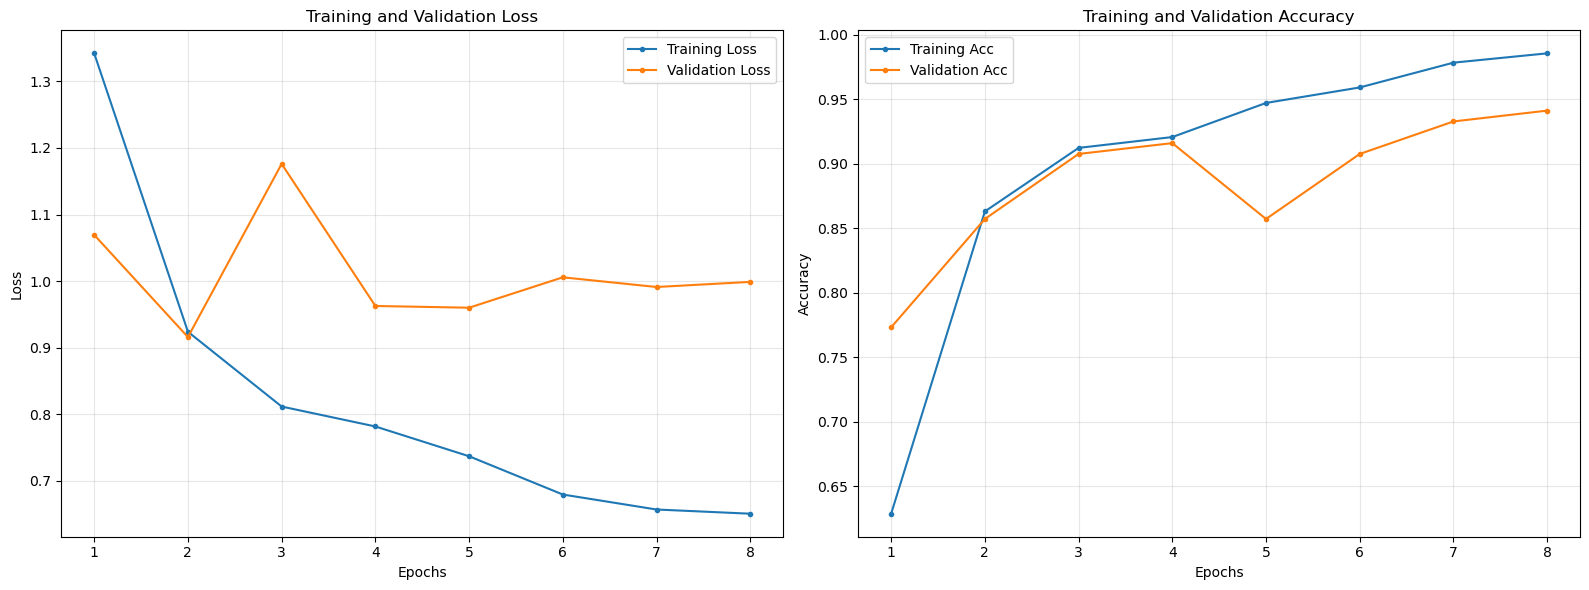


Running Inference on Test Set...


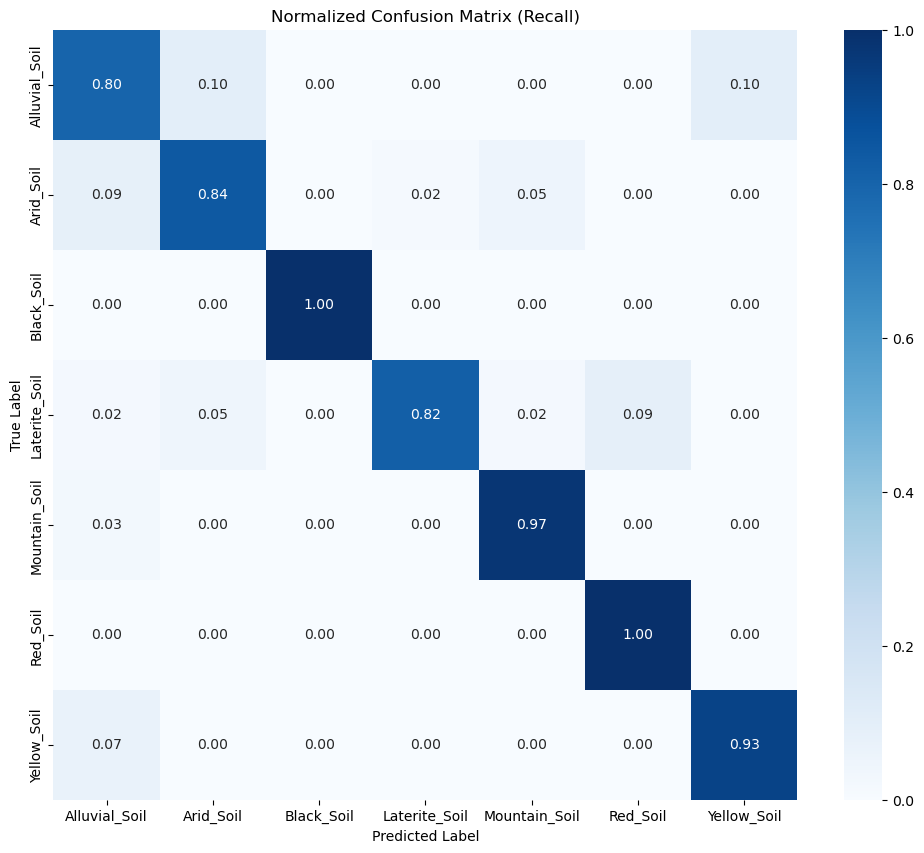

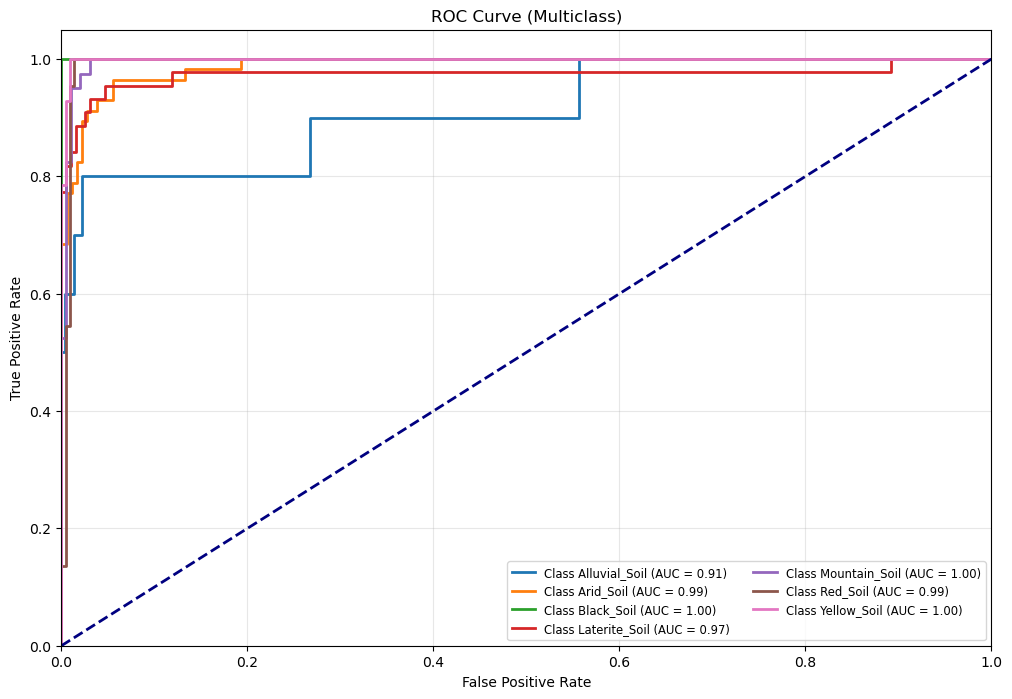

C:\Users\alera\AppData\Local\Temp\ipykernel_6104\1594838908.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x=class_names, y=per_class_accuracy, palette='viridis')
C:\Users\alera\AppData\Local\Temp\ipykernel_6104\1594838908.py:161: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x=class_names, y=per_class_f1, palette='magma')


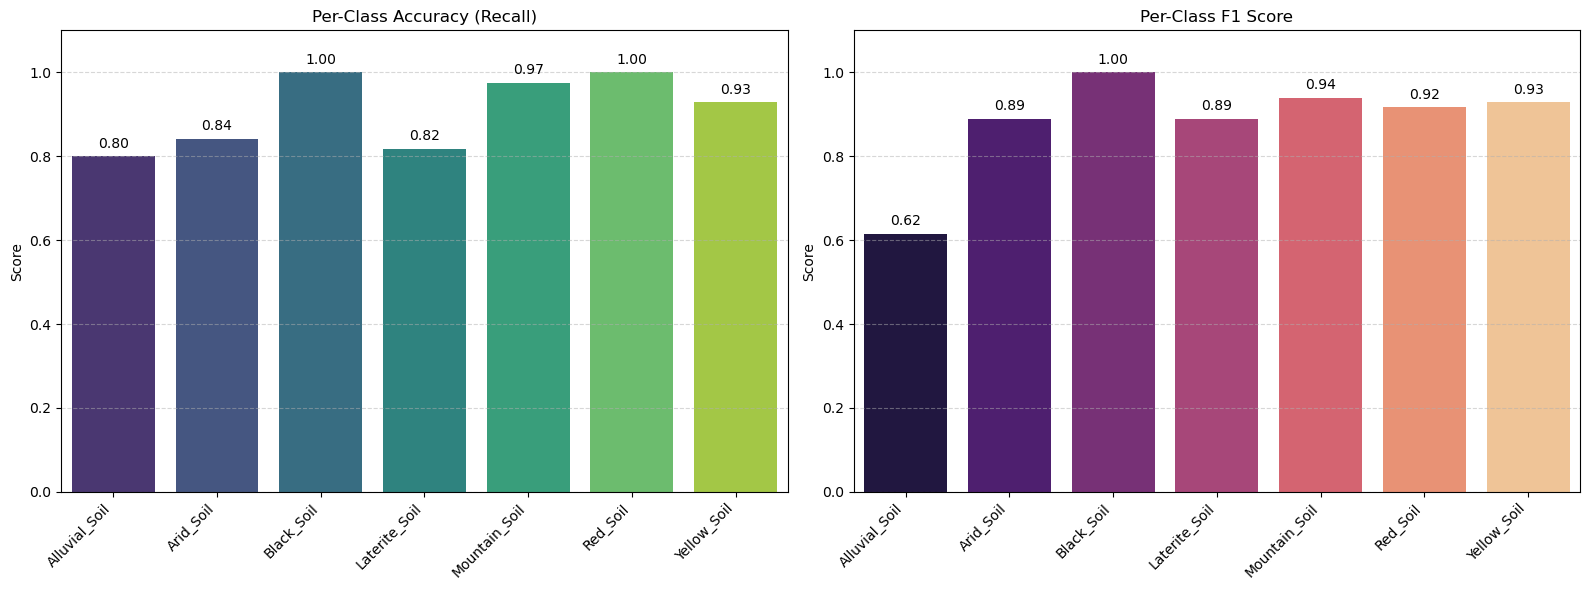

FINAL EVALUATION REPORT
               precision    recall  f1-score   support

Alluvial_Soil     0.5000    0.8000    0.6154        10
    Arid_Soil     0.9412    0.8421    0.8889        57
   Black_Soil     1.0000    1.0000    1.0000        51
Laterite_Soil     0.9730    0.8182    0.8889        44
Mountain_Soil     0.9070    0.9750    0.9398        40
     Red_Soil     0.8462    1.0000    0.9167        22
  Yellow_Soil     0.9286    0.9286    0.9286        14

     accuracy                         0.9118       238
    macro avg     0.8708    0.9091    0.8826       238
 weighted avg     0.9259    0.9118    0.9147       238


--------------------------------------------------
KPI SUMMARY
--------------------------------------------------
1. MODEL: Swin Transformer (Tiny Patch4 Window7 224)
2. DATASET: 238 Test Images
3. GLOBAL PERFORMANCE:
   - Total Accuracy:    91.18%
   - Top-5 Accuracy:    100.00%
   - Macro F1-Score:    0.8826
   - Macro Precision:   0.8708
   - Macro Recall:      

In [ ]:


# --- 1. Load Checkpoint ---
checkpoint_path = os.path.join(current_path, '..', 'models', 'best_model_transformer')
checkpoint = torch.load(checkpoint_path, map_location=device)

# Load weights
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
model.to(device)

# Load History and Classes
history = checkpoint.get('history', {})
class_names = checkpoint.get('class_names', full_data_train.classes) 
num_classes = len(class_names)

print("Model loaded successfully.")

# --- 2. Plot Training Stats (Loss & Accuracy) ---
if history:
    epochs_range = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['train_loss'], label='Train Loss')
    plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, [acc * 100 for acc in history['train_acc']], label='Train Accuracy')
    plt.plot(epochs_range, [acc * 100 for acc in history['val_acc']], label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

else:
    print("No training history found in checkpoint.")

# --- 3. Evaluate on Test Set ---
print("\nEvaluating on test set...")
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = test_correct / test_total * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Classification Report
report = classification_report(all_labels, all_preds, target_names=class_names)
print("\nClassification Report:\n", report)

# --- 4. Visualize Attention ---
print("\nGenerating attention visualization for a sample image...")
model.eval()
sample_input, sample_label = next(iter(test_loader))
sample_input = sample_input.to(device)
sample_label = sample_label.to(device)

with torch.no_grad():
    sample_output = model.forward_features(sample_input)
    attention_maps = model.forward_head(sample_output, pre_logits=True)

sample_input = sample_input.cpu().numpy()
mean_image = np.mean(sample_input[0], axis=0)
plt.imshow(mean_image, cmap='viridis')
plt.title(f"Sample Image - True Label: {class_names[sample_label[0]]}")
plt.show()

print("Notebook execution completed successfully.")